In [ ]:
#imports
import numpy as np 
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [55]:
df = pq.read_table(source="../data/chargecurves_train.parquet").to_pandas()
df.head(20)

,id,timestamp,soc,power,nominal_power,location_id,sub_id
0,1,2023-03-15 09:46:44,42.0,37.73,62.5,0,0
1,1,2023-03-15 09:47:44,44.0,30.10,62.5,0,1
2,1,2023-03-15 09:48:44,46.0,27.46,62.5,0,2
3,1,2023-03-15 09:49:44,49.0,26.42,62.5,0,3
4,1,2023-03-15 09:50:44,51.0,25.46,62.5,0,4
5,1,2023-03-15 09:51:44,53.0,23.55,62.5,0,5
6,1,2023-03-15 09:52:44,55.0,23.63,62.5,0,6
7,1,2023-03-15 09:53:44,56.0,22.46,62.5,0,7
8,1,2023-03-15 09:54:44,58.0,20.93,62.5,0,8
9,1,2023-03-15 09:55:44,60.0,20.18,62.5,0,9


In [56]:
df.isnull().sum()

id                  0
timestamp           0
soc              6081
power            7127
nominal_power       0
location_id         0
sub_id              0
dtype: int64

In [57]:
df.describe()

,id,timestamp,soc,power,nominal_power,location_id,sub_id
count,3.960349e+06,3960349,3.954268e+06,3.953222e+06,3.960349e+06,3.960349e+06,3.960349e+06
mean,6.987936e+04,2023-06-20 17:26:36.712216832,5.714675e+01,4.685585e+01,1.633075e+02,8.677634e+01,1.945163e+01
min,1.000000e+00,2022-01-01 02:42:08,1.000000e+00,0.000000e+00,5.000000e+01,0.000000e+00,0.000000e+00
25%,3.497300e+04,2022-12-13 13:28:22,4.200000e+01,2.864000e+01,6.250000e+01,2.800000e+01,9.000000e+00
50%,6.984200e+04,2023-08-01 12:08:28,5.800000e+01,4.452000e+01,1.700000e+02,7.100000e+01,1.900000e+01
75%,1.048190e+05,2024-01-17 15:48:11,7.300000e+01,5.944000e+01,2.000000e+02,1.290000e+02,2.900000e+01
max,1.400000e+05,2024-06-26 15:22:57,1.040000e+02,2.355480e+03,5.000000e+02,3.450000e+02,3.900000e+01
std,4.039902e+04,NaN,2.049384e+01,2.638718e+01,9.091005e+01,7.068857e+01,1.154053e+01


In [58]:
def reshape_dataframe(df):
    first_timestamps = df.groupby('id')['timestamp'].first().reset_index()

    pivot_df = df.pivot(index=['id', 'nominal_power', 'location_id'], 
                        columns='sub_id', 
                        values=['soc', 'power']).reset_index()
    pivot_df.columns = [
        f'{col[0]}_{col[1]}' if col[1] != '' else col[0] 
        for col in pivot_df.columns
    ]
    result_df = pivot_df.merge(first_timestamps, on='id')

    return result_df



In [59]:
df = reshape_dataframe(df)

In [60]:
df.head(20)



,id,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,soc_10,soc_11,soc_12,soc_13,soc_14,soc_15,soc_16,soc_17,soc_18,soc_19,soc_20,soc_21,soc_22,soc_23,soc_24,soc_25,soc_26,soc_27,soc_28,soc_29,soc_30,soc_31,soc_32,soc_33,soc_34,soc_35,soc_36,soc_37,soc_38,soc_39,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,power_10,power_11,power_12,power_13,power_14,power_15,power_16,power_17,power_18,power_19,power_20,power_21,power_22,power_23,power_24,power_25,power_26,power_27,power_28,power_29,power_30,power_31,power_32,power_33,power_34,power_35,power_36,power_37,power_38,power_39,timestamp
0,1,62.5,0,42.0,44.0,46.0,49.0,51.0,53.0,55.0,56.0,58.0,60.0,61.0,62.0,64.0,65.0,66.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,76.0,77.0,78.0,79.0,80.0,81.0,81.0,82.0,83.0,83.0,84.0,84.0,85.0,86.0,86.0,86.0,37.73,30.10,27.46,26.42,25.46,23.55,23.63,22.46,20.93,20.18,18.99,19.06,18.29,17.54,17.21,16.41,16.04,15.67,14.90,14.52,13.76,13.38,13.12,12.39,12.79,12.41,11.64,11.26,10.88,10.11,9.72,9.29,8.94,8.91,8.17,7.79,7.36,7.01,7.02,6.63,2023-03-15 09:46:44
1,2,360.0,1,26.0,26.0,28.0,29.0,31.0,32.0,34.0,36.0,37.0,39.0,41.0,42.0,44.0,46.0,48.0,49.0,51.0,53.0,54.0,56.0,58.0,59.0,61.0,62.0,64.0,65.0,67.0,68.0,69.0,71.0,72.0,73.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,0.00,66.06,66.79,67.69,68.61,70.25,71.91,73.93,75.97,76.18,76.01,76.96,72.72,74.03,74.97,74.80,73.88,73.32,72.38,70.31,68.60,67.64,67.06,65.70,64.34,63.74,62.76,61.76,61.15,60.14,58.35,57.72,56.16,54.35,54.10,53.06,52.40,51.35,49.10,47.12,2023-10-13 05:59:50
2,3,62.5,2,60.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,68.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,75.0,76.0,77.0,77.0,78.0,80.0,80.0,80.0,80.0,81.0,82.0,82.0,83.0,83.0,83.0,84.0,84.0,85.0,85.0,86.0,86.0,86.0,87.0,33.95,25.42,24.64,24.67,24.68,24.71,24.73,24.69,23.64,22.47,21.80,21.03,21.02,20.99,20.76,20.39,19.69,19.32,18.81,18.19,17.84,17.45,17.00,17.13,16.33,15.88,15.52,15.26,14.83,14.41,14.44,13.64,13.29,12.63,12.61,11.79,11.46,11.07,11.06,10.67,2024-01-23 04:21:08
3,4,50.0,3,59.0,59.0,60.0,61.0,61.0,62.0,63.0,63.0,64.0,64.0,65.0,65.0,66.0,66.0,67.0,67.0,68.0,68.0,69.0,69.0,70.0,70.0,71.0,71.0,71.0,72.0,72.0,72.0,73.0,73.0,73.0,74.0,74.0,74.0,75.0,75.0,75.0,76.0,76.0,76.0,0.00,17.95,13.43,14.66,13.16,12.82,12.85,11.72,11.37,11.40,11.02,10.67,10.67,10.70,11.08,10.70,10.75,10.31,10.37,10.37,9.60,9.98,8.83,8.83,8.79,9.22,8.81,9.24,9.22,9.22,8.83,9.26,8.88,8.86,8.49,6.91,7.30,7.32,7.30,7.70,2023-12-25 10:45:39
4,5,150.0,4,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,19.0,19.0,20.0,20.0,21.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,29.0,30.0,31.0,33.0,34.0,35.0,37.0,38.0,39.0,40.0,42.0,0.37,3.38,3.35,3.35,3.72,3.32,3.35,3.35,3.35,3.35,3.35,4.03,6.37,8.79,11.17,13.81,16.64,19.49,22.26,25.36,28.53,32.01,35.60,39.84,47.25,49.16,58.13,70.96,72.46,71.19,70.62,70.01,69.69,68.74,67.49,67.65,66.82,66.21,65.08,64.36,2022-12-12 18:39:31
5,9,200.0,7,22.0,24.0,26.0,29.0,31.0,33.0,35.0,38.0,40.0,42.0,45.0,46.0,49.0,50.0,54.0,56.0,58.0,60.0,62.0,64.0,67.0,69.0,71.0,73.0,75.0,76.0,78.0,80.0,81.0,84.0,85.0,86.0,88.0,90.0,91.0,92.0,93.0,93.0,95.0,96.0,38.34,38.72,38.80,38.88,39.02,39.04,39.19,39.27,39.38,39.45,39.57,39.61,39.76,39.92,39.66,39.82,39.89,39.75,39.73,39.61,39.02,38.39,38.03,37.32,37.13,36.45,36.21,35.58,34.66,32.61,30.17,28.05,25.88,24.25,22.78,21.31,19.94,18.49,17.11,15.65,2023-08-30 17:42:18
6,10,50.0,8,44.0,45.0,46.0,47.0,48.0,50.0,51.0,52.0,53.0,54.0,56.0,57.0,58.0,59.0,61.0,62.0,63.0,65.0,66.0,67.0,69.0,70.0,72.0,73.0,74.0,76.0,77.0,78.0,79.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,0.00,20.04,20.10,20.83,20.89,20.96,22.04,21.82,22.91,22.98,23.05,24.15,23.80,23.87,24.98,25.06,25.06,25.90,25.55,25.27,25.70,25.77,25.49,25.13,25.56,25.28,24.99,24.70,24.70,24.05,23.40,22.74,22.02,20.94,19.91,18.82,18.15,17.84,16.74,16.02,2022-12-02 17:30:14
7,12,150.0,10,27.0,28.0,28.0,29.0,29.0,29.0,30.0,30.0,30.0,31.0,31.0,31.0,32.0,32.0,32

In [61]:
df.isnull().sum()

id                  0
nominal_power       0
location_id         0
soc_0             428
soc_1             341
soc_2             359
soc_3             327
soc_4             330
soc_5             353
soc_6             375
soc_7             392
soc_8             398
soc_9             412
soc_10            421
soc_11            426
soc_12            436
soc_13            471
soc_14            513
soc_15            552
soc_16            584
soc_17            609
soc_18            641
soc_19            669
soc_20            696
soc_21            722
soc_22            744
soc_23            765
soc_24            783
soc_25            804
soc_26            821
soc_27            836
soc_28            857
soc_29            889
soc_30            914
soc_31           1012
soc_32           1047
soc_33           1117
soc_34           1153
soc_35           1207
soc_36           1265
soc_37           1329
soc_38           1406
soc_39           1568
power_0           282
power_1           313
power_2   

In [62]:
threshold = 15

# Find columns with more than half missing values
soc_cols = [f'soc_{i}' for i in range(10, 40)]
power_cols = [f'power_{i}' for i in range(10, 40)]

print((df[soc_cols].isna().sum(axis=1) > threshold).sum())
print((df[power_cols].isna().sum(axis=1) > threshold).sum())


783
821


In [63]:
power_cols = [f'power_{i}' for i in range(40)]

df['total_power'] = df[power_cols].sum(axis=1)

In [64]:
df.head(20)

,id,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,soc_10,soc_11,soc_12,soc_13,soc_14,soc_15,soc_16,soc_17,soc_18,soc_19,soc_20,soc_21,soc_22,soc_23,soc_24,soc_25,soc_26,soc_27,soc_28,soc_29,soc_30,soc_31,soc_32,soc_33,soc_34,soc_35,soc_36,soc_37,soc_38,soc_39,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,power_10,power_11,power_12,power_13,power_14,power_15,power_16,power_17,power_18,power_19,power_20,power_21,power_22,power_23,power_24,power_25,power_26,power_27,power_28,power_29,power_30,power_31,power_32,power_33,power_34,power_35,power_36,power_37,power_38,power_39,timestamp,total_power
0,1,62.5,0,42.0,44.0,46.0,49.0,51.0,53.0,55.0,56.0,58.0,60.0,61.0,62.0,64.0,65.0,66.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,76.0,77.0,78.0,79.0,80.0,81.0,81.0,82.0,83.0,83.0,84.0,84.0,85.0,86.0,86.0,86.0,37.73,30.10,27.46,26.42,25.46,23.55,23.63,22.46,20.93,20.18,18.99,19.06,18.29,17.54,17.21,16.41,16.04,15.67,14.90,14.52,13.76,13.38,13.12,12.39,12.79,12.41,11.64,11.26,10.88,10.11,9.72,9.29,8.94,8.91,8.17,7.79,7.36,7.01,7.02,6.63,2023-03-15 09:46:44,629.13
1,2,360.0,1,26.0,26.0,28.0,29.0,31.0,32.0,34.0,36.0,37.0,39.0,41.0,42.0,44.0,46.0,48.0,49.0,51.0,53.0,54.0,56.0,58.0,59.0,61.0,62.0,64.0,65.0,67.0,68.0,69.0,71.0,72.0,73.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,0.00,66.06,66.79,67.69,68.61,70.25,71.91,73.93,75.97,76.18,76.01,76.96,72.72,74.03,74.97,74.80,73.88,73.32,72.38,70.31,68.60,67.64,67.06,65.70,64.34,63.74,62.76,61.76,61.15,60.14,58.35,57.72,56.16,54.35,54.10,53.06,52.40,51.35,49.10,47.12,2023-10-13 05:59:50,2553.37
2,3,62.5,2,60.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,68.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,75.0,76.0,77.0,77.0,78.0,80.0,80.0,80.0,80.0,81.0,82.0,82.0,83.0,83.0,83.0,84.0,84.0,85.0,85.0,86.0,86.0,86.0,87.0,33.95,25.42,24.64,24.67,24.68,24.71,24.73,24.69,23.64,22.47,21.80,21.03,21.02,20.99,20.76,20.39,19.69,19.32,18.81,18.19,17.84,17.45,17.00,17.13,16.33,15.88,15.52,15.26,14.83,14.41,14.44,13.64,13.29,12.63,12.61,11.79,11.46,11.07,11.06,10.67,2024-01-23 04:21:08,739.91
3,4,50.0,3,59.0,59.0,60.0,61.0,61.0,62.0,63.0,63.0,64.0,64.0,65.0,65.0,66.0,66.0,67.0,67.0,68.0,68.0,69.0,69.0,70.0,70.0,71.0,71.0,71.0,72.0,72.0,72.0,73.0,73.0,73.0,74.0,74.0,74.0,75.0,75.0,75.0,76.0,76.0,76.0,0.00,17.95,13.43,14.66,13.16,12.82,12.85,11.72,11.37,11.40,11.02,10.67,10.67,10.70,11.08,10.70,10.75,10.31,10.37,10.37,9.60,9.98,8.83,8.83,8.79,9.22,8.81,9.24,9.22,9.22,8.83,9.26,8.88,8.86,8.49,6.91,7.30,7.32,7.30,7.70,2023-12-25 10:45:39,398.59
4,5,150.0,4,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,19.0,19.0,20.0,20.0,21.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,29.0,30.0,31.0,33.0,34.0,35.0,37.0,38.0,39.0,40.0,42.0,0.37,3.38,3.35,3.35,3.72,3.32,3.35,3.35,3.35,3.35,3.35,4.03,6.37,8.79,11.17,13.81,16.64,19.49,22.26,25.36,28.53,32.01,35.60,39.84,47.25,49.16,58.13,70.96,72.46,71.19,70.62,70.01,69.69,68.74,67.49,67.65,66.82,66.21,65.08,64.36,2022-12-12 18:39:31,1343.96
5,9,200.0,7,22.0,24.0,26.0,29.0,31.0,33.0,35.0,38.0,40.0,42.0,45.0,46.0,49.0,50.0,54.0,56.0,58.0,60.0,62.0,64.0,67.0,69.0,71.0,73.0,75.0,76.0,78.0,80.0,81.0,84.0,85.0,86.0,88.0,90.0,91.0,92.0,93.0,93.0,95.0,96.0,38.34,38.72,38.80,38.88,39.02,39.04,39.19,39.27,39.38,39.45,39.57,39.61,39.76,39.92,39.66,39.82,39.89,39.75,39.73,39.61,39.02,38.39,38.03,37.32,37.13,36.45,36.21,35.58,34.66,32.61,30.17,28.05,25.88,24.25,22.78,21.31,19.94,18.49,17.11,15.65,2023-08-30 17:42:18,1376.44
6,10,50.0,8,44.0,45.0,46.0,47.0,48.0,50.0,51.0,52.0,53.0,54.0,56.0,57.0,58.0,59.0,61.0,62.0,63.0,65.0,66.0,67.0,69.0,70.0,72.0,73.0,74.0,76.0,77.0,78.0,79.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,0.00,20.04,20.10,20.83,20.89,20.96,22.04,21.82,22.91,22.98,23.05,24.15,23.80,23.87,24.98,25.06,25.06,25.90,25.55,25.27,25.70,25.77,25.49,25.13,25.56,25.28,24.99,24.70,24.70,24.05,23.40,22.74,22.02,20.94,19.91,18.82,18.15,17.84,16.74,16.02,2022-12-02 17:30:14,887.21
7,12,150.0,10,27.0,28.

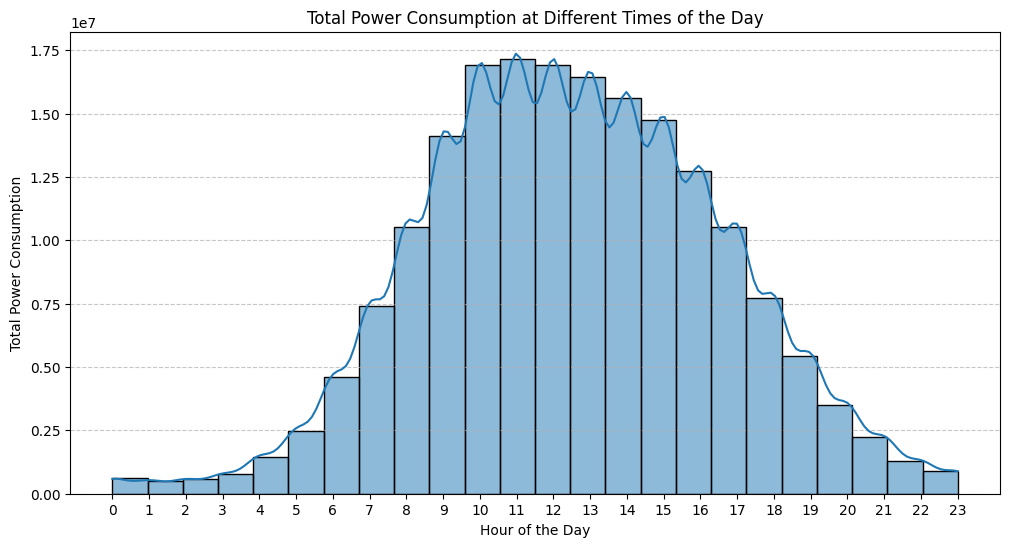

In [65]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Extract hour from timestamp
df['hour'] = df['timestamp'].dt.hour

# Plot histogram of total_power consumption by hour
plt.figure(figsize=(12, 6))
sns.histplot(df, x='hour', weights='total_power', bins=24, kde=True)

# Customize plot
plt.xlabel("Hour of the Day")
plt.ylabel("Total Power Consumption")
plt.title("Total Power Consumption at Different Times of the Day")
plt.xticks(range(0, 24))  # Ensure all hours are labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

C:\Users\gedvy\AppData\Local\Temp\ipykernel_9132\379339019.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_power.index, y=weekday_power.values, palette='viridis')


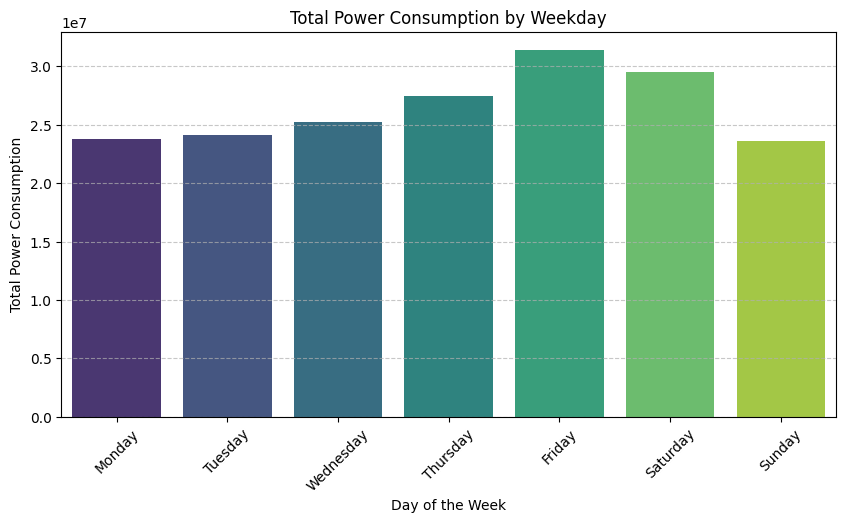

In [67]:
# Extract the weekday (0 = Monday, 6 = Sunday)
df['weekday'] = df['timestamp'].dt.dayofweek

# Map weekdays to names
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday_name'] = df['weekday'].map(lambda x: weekday_names[x])

# Aggregate total power consumption per weekday
weekday_power = df.groupby('weekday_name')['total_power'].sum().reindex(weekday_names)  # Ensure correct order

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_power.index, y=weekday_power.values, palette='viridis')

# Customize
plt.xlabel("Day of the Week")
plt.ylabel("Total Power Consumption")
plt.title("Total Power Consumption by Weekday")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [68]:
df.head(20)

,id,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,soc_10,soc_11,soc_12,soc_13,soc_14,soc_15,soc_16,soc_17,soc_18,soc_19,soc_20,soc_21,soc_22,soc_23,soc_24,soc_25,soc_26,soc_27,soc_28,soc_29,soc_30,soc_31,soc_32,soc_33,soc_34,soc_35,soc_36,soc_37,soc_38,soc_39,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,power_10,power_11,power_12,power_13,power_14,power_15,power_16,power_17,power_18,power_19,power_20,power_21,power_22,power_23,power_24,power_25,power_26,power_27,power_28,power_29,power_30,power_31,power_32,power_33,power_34,power_35,power_36,power_37,power_38,power_39,timestamp,total_power,hour,month,weekday,weekday_name
0,1,62.5,0,42.0,44.0,46.0,49.0,51.0,53.0,55.0,56.0,58.0,60.0,61.0,62.0,64.0,65.0,66.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,76.0,77.0,78.0,79.0,80.0,81.0,81.0,82.0,83.0,83.0,84.0,84.0,85.0,86.0,86.0,86.0,37.73,30.10,27.46,26.42,25.46,23.55,23.63,22.46,20.93,20.18,18.99,19.06,18.29,17.54,17.21,16.41,16.04,15.67,14.90,14.52,13.76,13.38,13.12,12.39,12.79,12.41,11.64,11.26,10.88,10.11,9.72,9.29,8.94,8.91,8.17,7.79,7.36,7.01,7.02,6.63,2023-03-15 09:46:44,629.13,9,3,2,Wednesday
1,2,360.0,1,26.0,26.0,28.0,29.0,31.0,32.0,34.0,36.0,37.0,39.0,41.0,42.0,44.0,46.0,48.0,49.0,51.0,53.0,54.0,56.0,58.0,59.0,61.0,62.0,64.0,65.0,67.0,68.0,69.0,71.0,72.0,73.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,0.00,66.06,66.79,67.69,68.61,70.25,71.91,73.93,75.97,76.18,76.01,76.96,72.72,74.03,74.97,74.80,73.88,73.32,72.38,70.31,68.60,67.64,67.06,65.70,64.34,63.74,62.76,61.76,61.15,60.14,58.35,57.72,56.16,54.35,54.10,53.06,52.40,51.35,49.10,47.12,2023-10-13 05:59:50,2553.37,5,10,4,Friday
2,3,62.5,2,60.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,68.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,75.0,76.0,77.0,77.0,78.0,80.0,80.0,80.0,80.0,81.0,82.0,82.0,83.0,83.0,83.0,84.0,84.0,85.0,85.0,86.0,86.0,86.0,87.0,33.95,25.42,24.64,24.67,24.68,24.71,24.73,24.69,23.64,22.47,21.80,21.03,21.02,20.99,20.76,20.39,19.69,19.32,18.81,18.19,17.84,17.45,17.00,17.13,16.33,15.88,15.52,15.26,14.83,14.41,14.44,13.64,13.29,12.63,12.61,11.79,11.46,11.07,11.06,10.67,2024-01-23 04:21:08,739.91,4,1,1,Tuesday
3,4,50.0,3,59.0,59.0,60.0,61.0,61.0,62.0,63.0,63.0,64.0,64.0,65.0,65.0,66.0,66.0,67.0,67.0,68.0,68.0,69.0,69.0,70.0,70.0,71.0,71.0,71.0,72.0,72.0,72.0,73.0,73.0,73.0,74.0,74.0,74.0,75.0,75.0,75.0,76.0,76.0,76.0,0.00,17.95,13.43,14.66,13.16,12.82,12.85,11.72,11.37,11.40,11.02,10.67,10.67,10.70,11.08,10.70,10.75,10.31,10.37,10.37,9.60,9.98,8.83,8.83,8.79,9.22,8.81,9.24,9.22,9.22,8.83,9.26,8.88,8.86,8.49,6.91,7.30,7.32,7.30,7.70,2023-12-25 10:45:39,398.59,10,12,0,Monday
4,5,150.0,4,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,19.0,19.0,20.0,20.0,21.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,29.0,30.0,31.0,33.0,34.0,35.0,37.0,38.0,39.0,40.0,42.0,0.37,3.38,3.35,3.35,3.72,3.32,3.35,3.35,3.35,3.35,3.35,4.03,6.37,8.79,11.17,13.81,16.64,19.49,22.26,25.36,28.53,32.01,35.60,39.84,47.25,49.16,58.13,70.96,72.46,71.19,70.62,70.01,69.69,68.74,67.49,67.65,66.82,66.21,65.08,64.36,2022-12-12 18:39:31,1343.96,18,12,0,Monday
5,9,200.0,7,22.0,24.0,26.0,29.0,31.0,33.0,35.0,38.0,40.0,42.0,45.0,46.0,49.0,50.0,54.0,56.0,58.0,60.0,62.0,64.0,67.0,69.0,71.0,73.0,75.0,76.0,78.0,80.0,81.0,84.0,85.0,86.0,88.0,90.0,91.0,92.0,93.0,93.0,95.0,96.0,38.34,38.72,38.80,38.88,39.02,39.04,39.19,39.27,39.38,39.45,39.57,39.61,39.76,39.92,39.66,39.82,39.89,39.75,39.73,39.61,39.02,38.39,38.03,37.32,37.13,36.45,36.21,35.58,34.66,32.61,30.17,28.05,25.88,24.25,22.78,21.31,19.94,18.49,17.11,15.65,2023-08-30 17:42:18,1376.44,17,8,2,Wednesday
6,10,50.0,8,44.0,45.0,46.0,47.0,48.0,50.0,51.0,52.0,53.0,54.0,56.0,57.0,58.0,59.0,61.0,62.0,63.0,65.0,66.0,67.0,69.0,70.0,72.0,73.0,74.0,76.0,77.0,78.0,79.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,0.00,20.04,20.10,20.83,20.89,20.96,22.04,21.82,22.91,22.98,23.05,24.15,23.80,23.87,24.98,25.06,25.06,25.90,25.55,25.27,25.70,25.77,25.49,25.13,25.56,25.28,24.99,24.7

In [ ]:

train, validation = train_test_split(df, train_size=0.70, test_size=0.15)
test, validation = train_test_split(validation, train_size=0.5)